## Good or Bad

In [1]:
from define_classes import *
from data_processing import *
from pca import *
from csv_clean import *
from polynomial_regression import *
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from sklearn.utils.class_weight import compute_sample_weight
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import recall_score, classification_report, accuracy_score, precision_score, precision_recall_curve
from sklearn.preprocessing import label_binarize
from ordinal import *
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier 

Using TensorFlow backend.


In [5]:
data = pd.read_csv('data.csv', index_col=0)
print('Possible thresdholds for classification:',np.sort(data['quality'].unique()))

Possible thresdholds for classification: [3 4 5 6 7 8 9]


In [6]:
target = 'cat'
n_c = 2 # bad, average, good wine
thres = [6]
value = 'quality'

import define_classes
# self,data:pd.DataFrame, target, n_c, thres: list or int, value
dt = define_classes.DefineTarget(data)
# self, target, n_c, thres: list or int, value
data = dt.get_classes(target, n_c, thres, value)

In [7]:
data.to_csv('two_classes.csv')

In [8]:
data['cat'].value_counts()

0    5220
1    1277
Name: cat, dtype: int64

In [9]:
# Splitting Data

csv = 'two_classes.csv'
y = 'cat'
d = DataClean(csv)
df_mm, num_scale = d.read_scale(csv)
X_train, X_test, y_train, y_test = d.split(csv, y)

In [10]:
# Balancing data

smt = SMOTE(sampling_strategy='not majority', k_neighbors=3)
X_train_s, y_train_s = smt.fit_sample(np.asarray(X_train), np.asarray(y_train))

col = list(num_scale.columns)

X_train_smote = pd.DataFrame(X_train_s, columns=col)
y_train_smote = pd.DataFrame(y_train_s, columns=['type'])

smote_df = X_train_smote.join(y_train_smote)

smote_df.groupby('type').count().iloc[:,0]

type
0    4173
1    4173
Name: fixedacidity, dtype: int64

### Comparing Classification Models performance

In [11]:
LR = LogisticRegression(random_state=0, solver='lbfgs', class_weight='balanced').fit(X_train_smote, y_train_smote)
y_lr = LR.predict(X_test)

SVM = SVC(decision_function_shape="ovr", class_weight='balanced').fit(X_train_smote, y_train_smote)
y_sv = SVM.predict(X_test)

RF = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=0, class_weight='balanced').fit(X_train_smote, y_train_smote)
y_rf = RF.predict(X_test)

NN = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(150, 10), random_state=1).fit(X_train_smote, y_train_smote)
y_nn = NN.predict(X_test)

/Users/flatironschool/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array w

In [12]:
model_predictions = [y_lr, y_sv, y_rf, y_nn]

In [13]:
names = ['y_lr', 'y_sv', 'y_rf', 'y_nn']

In [14]:
for y, n in zip(model_predictions, names):
    print('Accuracy_{}:'.format(n), round(accuracy_score(y_test, y), 3))
    print('Precision_{}:'.format(n), round(precision_score(y_test, y, average='weighted'),3))
    print('Recall_{}:'.format(n), round(recall_score(y_test,y, average='weighted'),3))
    print(classification_report(y_test, y))

Accuracy_y_lr: 0.715
Precision_y_lr: 0.827
Recall_y_lr: 0.715
              precision    recall  f1-score   support

           0       0.93      0.70      0.80      1047
           1       0.39      0.79      0.52       253

    accuracy                           0.71      1300
   macro avg       0.66      0.74      0.66      1300
weighted avg       0.83      0.71      0.74      1300

Accuracy_y_sv: 0.768
Precision_y_sv: 0.86
Recall_y_sv: 0.768
              precision    recall  f1-score   support

           0       0.96      0.74      0.84      1047
           1       0.45      0.87      0.59       253

    accuracy                           0.77      1300
   macro avg       0.70      0.81      0.72      1300
weighted avg       0.86      0.77      0.79      1300

Accuracy_y_rf: 0.835
Precision_y_rf: 0.873
Recall_y_rf: 0.835
              precision    recall  f1-score   support

           0       0.95      0.84      0.89      1047
           1       0.55      0.82      0.66       25

All of the classifiers perform well

Text(0.5, 257.44, 'Predicted label')

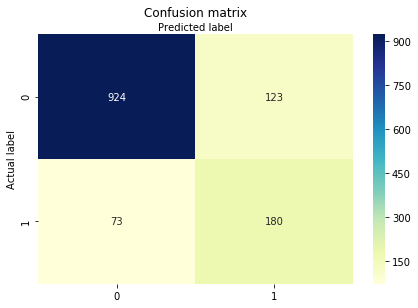

In [17]:
from sklearn import metrics

cnf_matrix = metrics.confusion_matrix(y_test, y_nn)
cnf_matrix

class_names=[0,1,2] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap='YlGnBu' ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

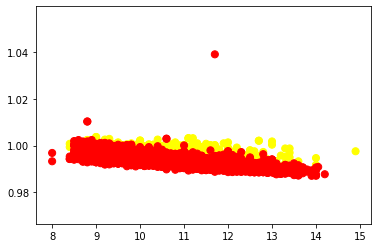

In [16]:
xfit = np.linspace(-1, 3.5)
plt.scatter(data['alcohol'], data['density'], c=data['type'], s=50, cmap='autumn')